In [1]:
%pip install -q blackscholes
%pip install -q equinox
%pip install -q exchange_calendars

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [62]:
import operator
from zoneinfo import ZoneInfo
import itertools
import datetime
import pandas as pd
import numpy as np
import equinox as eqx
import jax
from decimal import Decimal
import jax.numpy as jnp
from typing import Any, Callable, Literal
from collections import namedtuple, defaultdict
import pyarrow as pa
import string
import rich
from rich import progress

import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pydantic
from statsmodels.tsa.stattools import adfuller

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from functools import partial
import optax
# import redis
pd.set_option('display.max_columns', 500)

import exchange_calendars as xcals
import blackscholes

from functools import cache

In [3]:
# conn = redis.Redis(host='192.168.0.70', db=4, decode_responses=False)

In [4]:
# def get_dataframe_from_redis(conn: redis.Redis, key_prefix: str):
#     binary_data = conn.get(f"df:{key_prefix}:data")
#     if binary_data is None:
#         return None
#     df = pa.ipc.deserialize_pandas(binary_data)   
#     return df

In [5]:
if False:
    df_quotes = get_dataframe_from_redis(conn, 'volquote')
    df_quotes_with_ivmid = df_quotes.query('iv_mid==iv_mid')
    df_rolls = get_dataframe_from_redis(conn, 'rolls')
    df_futs = get_dataframe_from_redis(conn, 'futs')
if True:
    df_rolls = pd.read_csv('https://github.com/nkaimcaudle/ATC3Project202411/raw/refs/heads/main/data/rolls.csv.bz2', index_col=0, )
    for col in ['period_start', 'expiration', 'rolldatetime']:
        df_rolls[col] = pd.DatetimeIndex(pd.to_datetime(df_rolls[col], format='%Y-%m-%d %H:%M:%S%z', utc=True)).tz_convert('US/Eastern')

    df_futs = pd.read_csv('https://github.com/nkaimcaudle/ATC3Project202411/raw/refs/heads/main/data/futs.csv.bz2', index_col=0, )
    for col in ['timestamp', ]:
        df_futs[col] = pd.DatetimeIndex(pd.to_datetime(df_futs[col], format='%Y-%m-%d %H:%M:%S%z', utc=True)).tz_convert('US/Eastern')

    df_quotes = pd.read_csv('https://github.com/nkaimcaudle/ATC3Project202411/raw/refs/heads/main/data/quotes.csv.bz2', index_col=0, )
    for col in ['asof', 'expiration', 'fut_expiration']:
        df_quotes[col] = pd.DatetimeIndex(pd.to_datetime(df_quotes[col], format='%Y-%m-%d %H:%M:%S%z', utc=True)).tz_convert('US/Eastern')
    df_quotes_with_ivmid = df_quotes.query('iv_mid==iv_mid')

df_quotes.head()

,iv_model,fwd_model,symbol,asset,underlying,asof,expiration,fut_expiration,t,fwd,r,q,strike_price,instrument_class,bid,ask,iv_bid,iv_mid,iv_ask,log_strike,OTM
0,bs_root,r_box_fwd_synth_mcmc,ESM17 P1660,ES,ESM7,2017-05-22 15:48:00-04:00,2017-06-16 09:30:00-04:00,2017-06-16 09:30:00-04:00,0.067728,2393.312913,0.010207,NaN,1660.0,P,0.05,0.10,0.445278,0.460253,0.471709,-0.365861,True
1,bs_root,r_box_fwd_synth_mcmc,ESM17 P1700,ES,ESM7,2017-05-22 15:48:00-04:00,2017-06-16 09:30:00-04:00,2017-06-16 09:30:00-04:00,0.067728,2393.312913,0.010207,NaN,1700.0,P,0.10,0.15,0.443144,0.452056,0.459691,-0.342050,True
2,bs_root,r_box_fwd_synth_mcmc,ESM17 P1720,ES,ESM7,2017-05-22 15:48:00-04:00,2017-06-16 09:30:00-04:00,2017-06-16 09:30:00-04:00,0.067728,2393.312913,0.010207,NaN,1720.0,P,0.05,0.15,0.404772,0.429079,0.445168,-0.330354,True
3,bs_root,r_box_fwd_synth_mcmc,ESM17 P1730,ES,ESM7,2017-05-22 15:48:00-04:00,2017-06-16 09:30:00-04:00,2017-06-16 09:30:00-04:00,0.067728,2393.312913,0.010207,NaN,1730.0,P,0.05,0.15,0.398141,0.422100,0.437960,-0.324557,True
4,bs_root,r_box_fwd_synth_mcmc,ESM17 P1750,ES,ESM7,2017-05-22 15:48:00-04:00,2017-06-16 09:30:00-04:00,2017-06-16 09:30:00-04:00,0.067728,2393.312913,0.010207,NaN,1750.0,P,0.10,0.15,0.408242,0.416539,0.423650,-0.313063,True


In [6]:
def get_valid_asof_expirations(log_strike_min: float = -0.5, log_strike_max: float = 0.2, min_strikes: int = 5) -> tuple[list, dict]:
    m1 = df_AsOfUnderlyingExpiration[('t', 'count')].ge(min_strikes)
    m2 = df_AsOfUnderlyingExpiration[('log_strike', 'min')].le(log_strike_min)
    m3 = df_AsOfUnderlyingExpiration[('log_strike', 'max')].ge(log_strike_max)
    valid_AsOfs = df_AsOfUnderlyingExpiration.loc[m1 * m2 * m3].groupby(['asof']).count().ge(3).iloc[:, 0].pipe(lambda x: x.loc[x]).index
    valid_expirations = {asof: df_AsOfUnderlyingExpiration.loc[m1 * m2 * m3 * (df_AsOfUnderlyingExpiration.index.get_level_values(0)==asof)].index.get_level_values(1) for asof in valid_AsOfs}

    return valid_AsOfs, valid_expirations

df_AsOfUnderlyingExpiration = df_quotes_with_ivmid.dropna(subset=['fwd', 'iv_bid', 'iv_mid', 'iv_ask']).query('OTM').groupby(['asof', 'expiration', 'underlying', 't']).agg({'t': 'count', 'log_strike': ['min', 'max']})
valid_AsOfs, valid_expirations = get_valid_asof_expirations(log_strike_min=-0.5, log_strike_max=0.15, min_strikes=6)
len(valid_AsOfs), valid_AsOfs[0], valid_AsOfs[-1]

(1643,
 Timestamp('2017-06-02 15:48:00-0400', tz='US/Eastern'),
 Timestamp('2024-10-25 15:48:00-0400', tz='US/Eastern'))

In [7]:
strike_space = np.linspace(-0.5, 0.15, 11)

In [8]:
def get_date_X_y(asof: datetime.datetime, expirations: list[datetime.datetime], strike_space: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    mask = df_quotes_with_ivmid['asof'].eq(asof)
    mask = mask & df_quotes_with_ivmid['OTM'].eq(True)
    df_asof = df_quotes_with_ivmid.loc[mask]

    X = np.empty((3, strike_space.size))
    y = np.empty(3)
    for j, expiration in enumerate(expirations[:3]):
        df_expiration = df_asof.loc[df_asof['expiration'].eq(expiration)].sort_values('strike_price')
        u = df_expiration['log_strike'].values
        v = df_expiration['iv_mid'].values
        curve = scipy.interpolate.interp1d(u, v, kind='cubic', bounds_error=True)
        X[j, :] = curve(strike_space)
        y[j] = df_expiration['t'].iloc[0]
    return X, y
def get_data(dates, strike_space):
    X, y = [], []
    
    for date in dates:
        X_single, y_single = get_date_X_y(date, valid_expirations[date], strike_space)
        X.append(X_single)
        y.append(y_single)
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y
X, y = get_data(valid_AsOfs, strike_space)
X.shape, y.shape, np.isfinite(X).all(), np.isfinite(y).all()

((1643, 3, 11), (1643, 3), True, True)

In [9]:
class Encoder(eqx.Module):
    fc1: eqx.nn.Linear
    fc2: eqx.nn.Linear
    fc_mu: eqx.nn.Linear
    fc_logvar: eqx.nn.Linear

    def __init__(
        self,
        height: int,
        width: int,
        out_channels: int,
        latent_dim: int,
        hidden_dim: int,
        *,
        key,
    ):
        keys = jax.random.split(key, 4)
        self.fc1 = eqx.nn.Linear(height * width + height, hidden_dim, key=keys[0])
        self.fc2 = eqx.nn.Linear(hidden_dim, hidden_dim, key=keys[1])
        self.fc_mu = eqx.nn.Linear(hidden_dim, latent_dim, key=keys[2])
        self.fc_logvar = eqx.nn.Linear(hidden_dim, latent_dim, key=keys[3])

    def __call__(self, x, y):
        x = (x - 0.25) / 0.1
        x = x.ravel()
        combined = jnp.concatenate((x, y))
        h = jax.nn.silu(self.fc1(combined))
        h = jax.nn.silu(self.fc2(h))
        return self.fc_mu(h), self.fc_logvar(h)


class Decoder(eqx.Module):
    fc1: eqx.nn.Linear
    fc2: eqx.nn.Linear
    fc3: eqx.nn.Linear
    height: int
    width: int

    def __init__(
        self,
        height: int,
        width: int,
        out_channels: int,
        latent_dim: int,
        hidden_dim: int,
        *,
        key,
    ):
        keys = jax.random.split(key, 3)
        self.height = height
        self.width = width

        self.fc1 = eqx.nn.Linear(latent_dim + height, hidden_dim, key=keys[0])
        self.fc2 = eqx.nn.Linear(hidden_dim, hidden_dim, key=keys[1])
        self.fc3 = eqx.nn.Linear(hidden_dim, height * width, key=keys[2])

    def __call__(self, z, y):
        combined = jnp.concatenate((z, y))

        h = jax.nn.silu(self.fc1(combined))
        h = jax.nn.silu(self.fc2(h))
        h = self.fc3(h)
        return jax.nn.softplus(h).reshape(self.height, self.width)


class CVAE(eqx.Module):
    encoder: Encoder
    decoder: Decoder
    latent_dim: int
    width: int
    height: int
    hidden_dim: int

    def __init__(
        self,
        height: int,
        width: int,
        out_channels: int,
        latent_dim: int,
        hidden_dim: int,
        *,
        key,
    ):
        keys = jax.random.split(key, 2)
        self.encoder = Encoder(
            height=height,
            width=width,
            out_channels=out_channels,
            latent_dim=latent_dim,
            hidden_dim=hidden_dim,
            key=keys[0],
        )
        self.decoder = Decoder(
            height=height,
            width=width,
            out_channels=out_channels,
            latent_dim=latent_dim,
            hidden_dim=hidden_dim,
            key=keys[1],
        )
        self.latent_dim = latent_dim
        self.width = width
        self.height = height
        self.hidden_dim = hidden_dim

    def reparameterize(self, mu, logvar, *, key):
        std = jnp.exp(0.5 * logvar)
        eps = jax.random.normal(key, std.shape)
        return mu + eps * std

    def __call__(self, x, y, *, key) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar, key=key)
        return self.decoder(z, y), mu, logvar

In [10]:
def batch_index_generator(N_samples, batch_size=32):
    # Calculate the number of full batches
    num_full_batches = N_samples // batch_size

    # Generate indices for full batches
    for i in range(num_full_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        yield np.arange(start_idx, end_idx)

    # Check if there's a stub (remaining samples)
    remaining_samples = N_samples % batch_size
    if remaining_samples > 0:
        start_idx = num_full_batches * batch_size
        yield np.arange(start_idx, N_samples)

def correlation_loss(z):
    corr_matrix = jnp.corrcoef(z, rowvar=False)
    idxs = jnp.tril_indices(z.shape[1], k=-1)
    return jnp.power(corr_matrix[idxs], 2).mean()


def loss_fn(
    model: CVAE,
    x: jnp.ndarray,
    y: jnp.ndarray,
    *,
    key,
    kl_loss_alpha,
    correl_loss_alpha,
) -> jnp.ndarray:
    _fn = lambda a, b: model(a, b, key=key)
    recon_x, mu, logvar = jax.vmap(_fn)(x, y)

    recon_loss = jnp.power(x - recon_x, 2).mean((-2, -1)).mean()
    kl_loss = -0.5 * jnp.mean(1 + logvar - mu**2 - jnp.exp(logvar))
    correl_loss = correlation_loss(mu) if mu.shape[1] > 1 else 0.0

    return recon_loss + kl_loss_alpha * kl_loss + correl_loss_alpha * correl_loss


@eqx.filter_value_and_grad
def batch_loss(
    model: CVAE,
    x: jnp.ndarray,
    y: jnp.ndarray,
    *,
    key,
    kl_loss_alpha: float = 1.0,
    correl_loss_alpha: float = 1.0,
) -> jnp.ndarray:
    return loss_fn(
        model,
        x,
        y,
        key=key,
        kl_loss_alpha=kl_loss_alpha,
        correl_loss_alpha=correl_loss_alpha,
    )


@eqx.filter_jit
def make_step(
    model: CVAE,
    x: jnp.ndarray,
    y: jnp.ndarray,
    opt_state,
    optimizer,
    *,
    key,
    kl_loss_alpha: float = 1.0,
    correl_loss_alpha: float = 1.0,
):
    loss, grads = batch_loss(
        model,
        x,
        y,
        key=key,
        kl_loss_alpha=kl_loss_alpha,
        correl_loss_alpha=correl_loss_alpha,
    )
    updates, opt_state = optimizer.update(
        grads, opt_state, eqx.filter(model, eqx.is_array)
    )
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

def evaluate_model(model: Callable, X, y) -> dict[str, Any]:
    _fn = lambda a, b: model(a, b, key=jax.random.PRNGKey(0))
    reconstructed, latent, logvar = jax.vmap(_fn)(X, y)
    metrics = dict(
        latent_dim=latent.shape[1],
        recon_loss=np.power(reconstructed - X, 2).mean().item(),
        KL_loss=-0.5 * np.mean(1 + logvar - latent**2 - np.exp(logvar)).item(),
        correl_loss=correlation_loss(latent).item(),
        logpdf=jax.scipy.stats.norm.logpdf(latent, loc=0.0, scale=1.0).mean().item(),
    )
    for j in range(latent.shape[1]):
        metrics[f"loc_{j}"] = latent[:, j].mean().item()
        metrics[f"scale_{j}"] = latent[:, j].std().item()
    metrics["loc_"] = latent.mean().item()
    metrics["scale_"] = latent.std().mean().item()
    return metrics

In [11]:
TRAIN_PERCENT = 0.7
train_idx = np.arange(int(X.shape[0] * TRAIN_PERCENT))
test_idx = np.arange(train_idx.size, X.shape[0])

print(f'Training set {valid_AsOfs[train_idx[[0, -1]]].values}, {len(train_idx)} days')
print(f'Testing set {valid_AsOfs[test_idx[[0, -1]]].values}, {len(test_idx)} days')

Training set ['2017-06-02T19:48:00.000000000' '2022-10-26T19:48:00.000000000'], 1150 days
Testing set ['2022-10-27T19:48:00.000000000' '2024-10-25T19:48:00.000000000'], 493 days


In [12]:
def run_for_param_set(latent_dim: int, out_channels: int, hidden_dim: int, seed: int, learning_rate: float, kl_loss_alpha: float, correl_loss_alpha: float, num_epochs: int, to_run_idx: np.ndarray, test_count: int) -> tuple[float, CVAE, np.ndarray]:
    print_every = num_epochs // 20
    key_init, key_loop, key_test = jax.random.split(jax.random.PRNGKey(seed), 3)
    model = CVAE(
        height=X.shape[1],
        width=X.shape[2],
        latent_dim=latent_dim,
        out_channels=out_channels,
        hidden_dim=hidden_dim,
        key=key_init,
    )
    optimizer = optax.adamw(learning_rate=learning_rate)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    losses = []

    train_idx = to_run_idx[:-test_count]
    test_idx = to_run_idx[-test_count:]
    
    cv_best_loss = np.inf
    best_model = None
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        batch_generator = batch_index_generator(train_idx.size)
        for batch_idx in batch_generator:
            batch_x = X[train_idx][batch_idx]
            batch_y = y[train_idx][batch_idx]
            
            key_loop, key_train, key_test = jax.random.split(key_loop, 3)
            loss, model, opt_state = make_step(model, batch_x, batch_y, opt_state, optimizer, key=key_train, kl_loss_alpha=kl_loss_alpha, correl_loss_alpha=correl_loss_alpha)
            epoch_loss += loss.item()
        losses.append(epoch_loss)
    
        test_loss = loss_fn(model, X[test_idx], y[test_idx], key=key_test, kl_loss_alpha=kl_loss_alpha, correl_loss_alpha=correl_loss_alpha).item()
        if test_loss < cv_best_loss:
            cv_best_loss = test_loss
            best_model = model
        if (epoch % print_every) == 0 or (epoch == num_epochs - 1):
            print(f'{epoch=:4}, {epoch_loss=:8.4f} {test_loss=:7.4f} {np.log(test_loss)=:5.2f}')
    return cv_best_loss, best_model, np.asarray(losses)

In [13]:
BEST_PARAMS = dict(latent_dim=4, out_channels=0, hidden_dim=48, learning_rate=0.000562, kl_loss_alpha=0.00001, correl_loss_alpha=0.00001, seed=0, num_epochs=2000)
best_loss, best_model, losses = run_for_param_set(**BEST_PARAMS, to_run_idx=train_idx, test_count=250)

epoch=   0, epoch_loss=  5.4909 test_loss= 0.1379 np.log(test_loss)=-1.98
epoch= 100, epoch_loss=  0.0099 test_loss= 0.0006 np.log(test_loss)=-7.47
epoch= 200, epoch_loss=  0.0067 test_loss= 0.0002 np.log(test_loss)=-8.36
epoch= 300, epoch_loss=  0.0039 test_loss= 0.0002 np.log(test_loss)=-8.51
epoch= 400, epoch_loss=  0.0025 test_loss= 0.0002 np.log(test_loss)=-8.80
epoch= 500, epoch_loss=  0.0034 test_loss= 0.0002 np.log(test_loss)=-8.65
epoch= 600, epoch_loss=  0.0028 test_loss= 0.0001 np.log(test_loss)=-8.95
epoch= 700, epoch_loss=  0.0020 test_loss= 0.0001 np.log(test_loss)=-8.94
epoch= 800, epoch_loss=  0.0020 test_loss= 0.0001 np.log(test_loss)=-8.92
epoch= 900, epoch_loss=  0.0019 test_loss= 0.0001 np.log(test_loss)=-8.92
epoch=1000, epoch_loss=  0.0020 test_loss= 0.0001 np.log(test_loss)=-9.00
epoch=1100, epoch_loss=  0.0017 test_loss= 0.0001 np.log(test_loss)=-9.07
epoch=1200, epoch_loss=  0.0016 test_loss= 0.0001 np.log(test_loss)=-9.03
epoch=1300, epoch_loss=  0.0016 test_l

In [14]:
recon_x, latent, logvar = jax.vmap(lambda a, b: best_model(a, b, key=jax.random.PRNGKey(0)))(X[train_idx], y[train_idx])
recon_x.shape, latent.shape, logvar.shape

((1150, 3, 11), (1150, 4), (1150, 4))

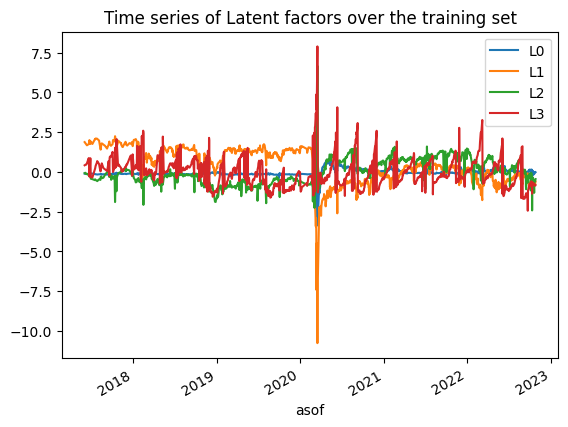

In [15]:
pd.DataFrame(latent, index=valid_AsOfs[train_idx], columns=[f'L{j}' for j in range(latent.shape[1])]).plot(title='Time series of Latent factors over the training set');

Correlation of the latent factors

In [16]:
np.corrcoef(latent.T).round(2)

array([[ 1.  , -0.1 ,  0.28, -0.2 ],
       [-0.1 ,  1.  , -0.43, -0.15],
       [ 0.28, -0.43,  1.  ,  0.13],
       [-0.2 , -0.15,  0.13,  1.  ]])

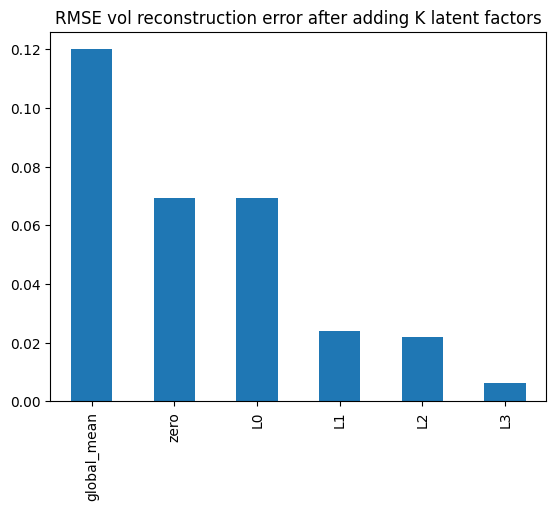

In [17]:
def plot_mse_reconX(latent, X, y):
    zero = jax.vmap(best_model.decoder)(latent * 0., y)
    L0 = jax.vmap(best_model.decoder)(latent * jnp.asarray([1, 0, 0, 0]), y)
    L1 = jax.vmap(best_model.decoder)(latent * jnp.asarray([1, 1, 0, 0]), y)
    L2 = jax.vmap(best_model.decoder)(latent * jnp.asarray([1, 1, 1, 0]), y)
    L3 = jax.vmap(best_model.decoder)(latent, y)
    lst = [
        np.power(X - X.mean(), 2).mean((-2, -1)).mean() ** 0.5,
        np.power(X - zero, 2).mean((-2, -1)).mean() ** 0.5,
        np.power(X - L0, 2).mean((-2, -1)).mean() ** 0.5,
        np.power(X - L1, 2).mean((-2, -1)).mean() ** 0.5,
        np.power(X - L2, 2).mean((-2, -1)).mean() ** 0.5,
        np.power(X - L3, 2).mean((-2, -1)).mean() ** 0.5,
    ]
    ax = pd.Series(lst, index=['global_mean', 'zero', 'L0', 'L1', 'L2', 'L3']).plot(kind='bar', title='RMSE vol reconstruction error after adding K latent factors');
    return ax
plot_mse_reconX(latent, X[train_idx], y[train_idx]);

The neural network has learnt the general shape of the ES volatility surface, this can be seen by the "zero" column which means setting the latent factors to zero for all the training days, the MSE error reduces from 12v to 7v. 
L0 and L1 don't materially improve the fit of the volatility surface. L2 provides a big improvement, this is likely to be the general level of the vol, equivalent to a parallel shift of the entire surface. L3 further enhances the fit, this is likely either a skew dynamic across strikes or a term structure dynamic across expirations. 

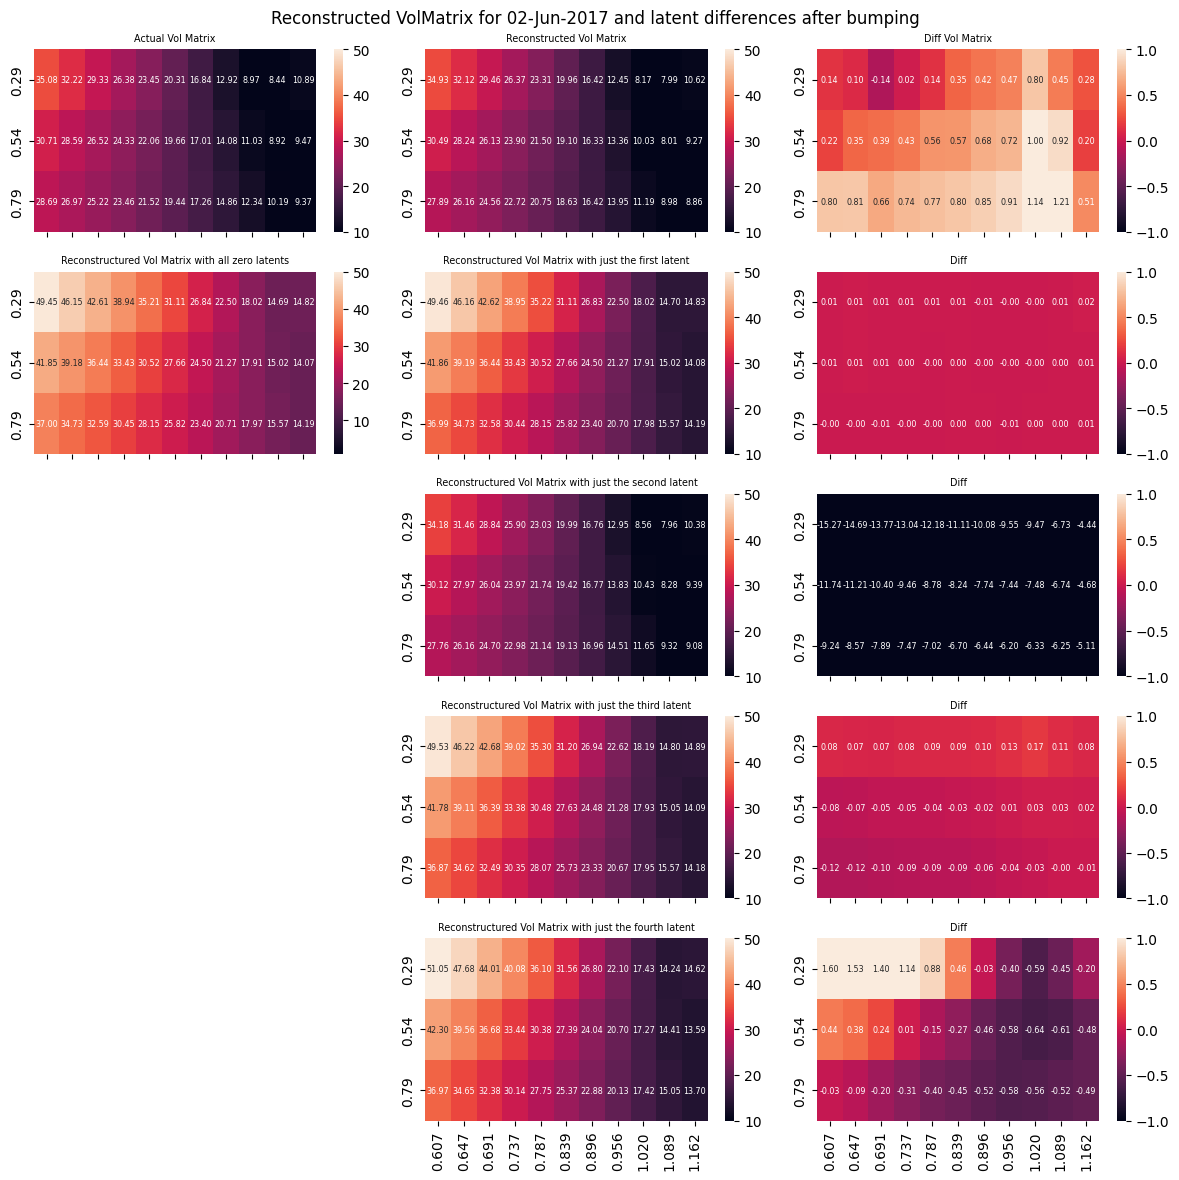

In [18]:
def show_single_volmatrix_with_latent_shift(actual, y, strike_space, latent, model, date):
    fig, axs = plt.subplots(5, 3, figsize=(12, 12), sharex=True)

    x_labels = [f'{t:.3f}' for t in np.exp(strike_space)]
    y_labels = [f'{t:.2f}' for t in y]
    heatmap = partial(sns.heatmap, xticklabels=x_labels, yticklabels=y_labels, annot=True, annot_kws={'fontsize': 'xx-small', }, fmt='.2f')
    heatmap100 = lambda x, *args, **kwargs: heatmap(100.*x, *args, **kwargs)
    
    heatmap100(actual, ax=axs[0, 0], vmin=10, vmax=50, )
    axs[0, 0].set_title('Actual Vol Matrix', fontsize='x-small');
    heatmap100(model.decoder(latent, y, ), ax=axs[0, 1], vmin=10, vmax=50, )
    axs[0, 1].set_title('Reconstructed Vol Matrix', fontsize='x-small');
    heatmap100(actual - model.decoder(latent, y, ), ax=axs[0, 2], vmin=-1, vmax=1, )
    axs[0, 2].set_title('Diff Vol Matrix', fontsize='x-small');

    BASE = model.decoder(np.zeros(4), y, )
    heatmap100(BASE, ax=axs[1, 0], vmin=1, vmax=50, )
    heatmap100(model.decoder(latent * np.asarray([1, 0, 0, 0]), y, ), ax=axs[1, 1], vmin=10, vmax=50, )
    heatmap100(model.decoder(latent * np.asarray([1, 0, 0, 0]), y, ) - BASE, ax=axs[1, 2], vmin=-1, vmax=1, )
    axs[1, 0].set_title('Reconstructured Vol Matrix with all zero latents', fontsize='x-small');
    axs[1, 1].set_title('Reconstructured Vol Matrix with just the first latent', fontsize='x-small');
    axs[1, 2].set_title('Diff', fontsize='x-small');

    heatmap100(model.decoder(latent * np.asarray([0, 1, 0, 0]), y, ), ax=axs[2, 1], vmin=10, vmax=50, )
    heatmap100(model.decoder(latent * np.asarray([0, 1, 0, 0]), y, ) - BASE, ax=axs[2, 2], vmin=-1, vmax=1, )
    axs[2, 1].set_title('Reconstructured Vol Matrix with just the second latent', fontsize='x-small');
    axs[2, 2].set_title('Diff', fontsize='x-small');

    heatmap100(model.decoder(latent * np.asarray([0, 0, 1, 0]), y, ), ax=axs[3, 1], vmin=10, vmax=50, )
    heatmap100(model.decoder(latent * np.asarray([0, 0, 1, 0]), y, ) - BASE, ax=axs[3, 2], vmin=-1, vmax=1, )
    axs[3, 1].set_title('Reconstructured Vol Matrix with just the third latent', fontsize='x-small');
    axs[3, 2].set_title('Diff', fontsize='x-small');

    heatmap100(model.decoder(latent * np.asarray([0, 0, 0, 1]), y, ), ax=axs[4, 1], vmin=10, vmax=50, )
    heatmap100(model.decoder(latent * np.asarray([0, 0, 0, 1]), y, ) - BASE, ax=axs[4, 2], vmin=-1, vmax=1, )
    axs[4, 1].set_title('Reconstructured Vol Matrix with just the fourth latent', fontsize='x-small');
    axs[4, 2].set_title('Diff', fontsize='x-small');
    
    fig.delaxes(axs[2, 0])
    fig.delaxes(axs[3, 0])
    fig.delaxes(axs[4, 0])

    fig.suptitle(f'Reconstructed VolMatrix for {date.strftime("%d-%b-%Y")} and latent differences after bumping')
k = 0
show_single_volmatrix_with_latent_shift(X[k], y[k], strike_space, latent[k], best_model, valid_AsOfs[k])
plt.tight_layout()

In [19]:
def traditional_metrics_func(x, y):
    x = np.asarray(x)
    return dict(
        atmf=x[1, 8],
        ts=x[2, 8] - x[0, 8],
        skew=x[1, 6] - x[1, 9],
        norm_skew=(x[1, 6] - x[1, 9]) / x[1, 8],
        smile=0.5*(x[1, 6] + x[1, 9]) - x[1, 8],
    )

In [20]:
def get_traditional_metrics_comparison(actual, y, latent, model, ):
    res = dict(actual=traditional_metrics_func(actual, y))
    reconstructed = best_model.decoder(latent, y)
    res['reconstructed'] = traditional_metrics_func(reconstructed, y)
    res['diff'] = jax.tree_util.tree_map(operator.sub, res['reconstructed'], res['actual'])
    for L in range(4):
        grid = best_model.decoder(latent + np.eye(4)[L], y)
        res[f'L{L}_bumped'] = traditional_metrics_func(grid, y)
        res[f'L{L}_diff'] = jax.tree_util.tree_map(operator.sub, res[f'L{L}_bumped'], res['reconstructed'])
    return pd.DataFrame(res).T
k = 1000
get_traditional_metrics_comparison(X[k], y[k], latent[k], best_model).round(4)

,atmf,ts,skew,norm_skew,smile
actual,0.2507,-0.0085,0.0972,0.3878,0.0110
reconstructed,0.2455,-0.0067,0.1008,0.4104,0.0167
diff,-0.0052,0.0018,0.0036,0.0227,0.0056
L0_bumped,0.2459,-0.0088,0.1023,0.4161,0.0155
L0_diff,0.0004,-0.0022,0.0015,0.0056,-0.0012
L1_bumped,0.1809,0.0121,0.0955,0.5281,0.0188
L1_diff,-0.0646,0.0188,-0.0052,0.1177,0.0021
L2_bumped,0.2456,0.0245,0.1087,0.4424,0.0167
L2_diff,0.0001,0.0312,0.0079,0.0320,0.0000
L3_bumped,0.2300,-0.0067,0.1074,0.4672,0.0182


z-score of actual vol matrix versus reconstructed one over the training set

In [21]:
def expanding_z(arr: np.ndarray) -> np.ndarray:
    df_ = pd.DataFrame(arr.reshape(arr.shape[0], -1))
    df_expanding = df_.expanding()
    _std = df_expanding.std()
    _std = np.where(np.isfinite(_std), _std, 1.)
    out = ((df_ - df_expanding.mean()) / _std).values
    return out.reshape(arr.shape)

In [22]:
X_error = X[train_idx] - recon_x
X_error_z = expanding_z(X_error)

In [61]:
for j in range(X_error_z.shape[1]):
    for k in range(X_error_z.shape[2]):
        adf = adfuller(X_error_z[:, j, k])
        print(f'StrikeVol node {j=:2}, {k=:2} Augmented Dickey-Fuller unit root test p-value {adf[1]:.4f}')

StrikeVol node j= 0, k= 0 Augmented Dickey-Fuller unit root test p-value 0.0000
StrikeVol node j= 0, k= 1 Augmented Dickey-Fuller unit root test p-value 0.0000
StrikeVol node j= 0, k= 2 Augmented Dickey-Fuller unit root test p-value 0.0000
StrikeVol node j= 0, k= 3 Augmented Dickey-Fuller unit root test p-value 0.0000
StrikeVol node j= 0, k= 4 Augmented Dickey-Fuller unit root test p-value 0.0000
StrikeVol node j= 0, k= 5 Augmented Dickey-Fuller unit root test p-value 0.0000
StrikeVol node j= 0, k= 6 Augmented Dickey-Fuller unit root test p-value 0.0000
StrikeVol node j= 0, k= 7 Augmented Dickey-Fuller unit root test p-value 0.0000
StrikeVol node j= 0, k= 8 Augmented Dickey-Fuller unit root test p-value 0.0000
StrikeVol node j= 0, k= 9 Augmented Dickey-Fuller unit root test p-value 0.0000
StrikeVol node j= 0, k=10 Augmented Dickey-Fuller unit root test p-value 0.0000
StrikeVol node j= 1, k= 0 Augmented Dickey-Fuller unit root test p-value 0.0010
StrikeVol node j= 1, k= 1 Augmented Dick

In [64]:
def half_life_numpy(prices: np.ndarray) -> float:
    lag = prices[:-1]
    delta = prices[1:] - prices[:-1]
    
    mask = np.isfinite(lag) & np.isfinite(delta)
    lag = lag[mask]
    delta = delta[mask]
    
    try:
        X = lag.reshape(-1, 1)
        X = np.c_[np.ones_like(lag), lag]
        
        # Solve linear equation: delta = 1 + theta * lag
        theta = np.linalg.lstsq(X, delta, rcond=None)
        theta_lag = theta[0][1]
        
        # Check if mean-reverting
        if theta_lag < 0:
            half_life = -np.log(2) / theta_lag
            return half_life if np.isfinite(half_life) else np.inf
        else:
            return np.inf
            
    except:
        return np.inf

In [24]:
half_lifes = np.empty_like(X[0])
for j in range(half_lifes.shape[0]):
    for k in range(half_lifes.shape[1]):
        half_lifes[j, k] = half_life_numpy(X_error_z[:, j, k])
half_lifes.round(2)

array([[2.38, 3.07, 2.63, 2.61, 3.34, 2.91, 2.36, 1.99, 2.38, 1.76, 1.61],
       [2.16, 2.27, 2.47, 2.92, 2.69, 2.03, 1.57, 1.29, 1.68, 2.87, 3.18],
       [2.8 , 2.2 , 2.09, 2.14, 1.9 , 1.84, 2.15, 1.01, 1.14, 3.54, 4.53]])

In [25]:
half_lifes.mean()

2.348617983120195

In [26]:
def letter_combinations():
    letters = string.ascii_uppercase  # 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for combination in itertools.product(letters, repeat=4):
        yield "".join(combination)
generator = letter_combinations()
primary_key_func = lambda: next(generator)

In [27]:
class SecurityModel(pydantic.BaseModel):
    symbol: str
    expiration: pydantic.AwareDatetime
    security_type: str
    strike: float
    is_call: int
    underlying: str

class ExecutionModel(pydantic.BaseModel):
    pk: str = pydantic.Field(default_factory=primary_key_func)
    when: pydantic.AwareDatetime
    symbol: str
    price: float
    qty: Decimal
    comment: str = ""

    @property
    def proceeds(self) -> float:
        return self.price * -float(self.qty)

class TradeModel(pydantic.BaseModel):
    pk: str = pydantic.Field(default_factory=primary_key_func)
    opened: pydantic.AwareDatetime
    closed: pydantic.AwareDatetime | None = None
    opt_executions: list[ExecutionModel] = []
    fut_executions: list[ExecutionModel] = []

    def get_all_cash(self) -> float:
        cash = 0.
        for opt in self.opt_executions:
            cash += opt.proceeds
        for fut in self.fut_executions:
            cash += fut.proceeds
        return cash

class PortfolioModel(pydantic.BaseModel):
    executions: list[ExecutionModel]

    @property
    def open_positions(self) -> dict[str, Decimal]:
        res = defaultdict(Decimal)
        for exc in self.executions:
            res[exc.symbol] += exc.qty
        return {key: value for key, value in res.items() if value != 0}

class ContextModel(pydantic.BaseModel):
    model_config = pydantic.ConfigDict(arbitrary_types_allowed=True)

    dt: pydantic.AwareDatetime
    date_j: int
    session_j: int
    session_name: str
    portfolio: PortfolioModel
    definitions: dict[str, Any]

class SnapshotModel(pydantic.BaseModel):
    when: pydantic.AwareDatetime
    cash: float
    transaction_costs: float
    assets_value: float
    balance_sheet: float
    n_trades: int
    n_open_trades: int

class PriceRiskModel(pydantic.BaseModel):
    price: float
    delta: float
    gamma: float
    vega: float
    theta: float

class TargetModel(pydantic.BaseModel):
    symbol: str
    strike: float

In [65]:
def signal_to_qty(signal: float) -> Decimal:
    if signal>DOWNSIDE_BREACH and signal < UPSIDE_BREACH:
        return Decimal(0)
    if signal < DOWNSIDE_BREACH:
        return Decimal(1)
    return Decimal(-1)

def find_target(date: datetime.datetime, expiration: datetime.datetime, log_strike: float) -> TargetModel:
    df_ = df_quotes.loc[df_quotes['asof'].eq(date) & df_quotes['expiration'].eq(expiration) & df_quotes['OTM']]
    df_ = df_.assign(strike_diff=lambda x: x['log_strike'] - log_strike)
    df_ = df_.assign(strike_diff_sq=lambda x: x['strike_diff']**2)
    best = df_.nsmallest(1, 'strike_diff_sq').iloc[0]
    return TargetModel(symbol=best['symbol'], strike=best['strike_price'])

def find_exec_px(date: datetime.datetime, symbol: str, qty: Decimal) -> float:
    df_ = df_quotes.loc[df_quotes['asof'].eq(date) & df_quotes['symbol'].eq(symbol)]
    if len(df_)==0:
        raise ValueError(f'{symbol} price not found for {date=}')
    
    bid = df_['bid'].item()
    ask = df_['ask'].item()
    if qty > 0 and np.isfinite(ask):
        return ask
    elif np.isfinite(bid):
        return bid
    return ask

def get_security(symbol: str) -> SecurityModel | None:
    if ' ' in symbol:
        try:
            row = df_quotes.loc[df_quotes['symbol'].eq(symbol)].iloc[0]
            return SecurityModel(symbol=symbol, expiration=row.expiration, security_type='OPT', is_call=int(row.instrument_class == 'C'), underlying=row.underlying, strike=row.strike_price)
        except IndexError:
            return None
    try:
        row = df_rolls.loc[df_rolls['near_symbol'].eq(symbol)].iloc[0]
        return SecurityModel(symbol=symbol, expiration=row.expiration, security_type='FUT', is_call=0, underlying=symbol, strike=0.)
    except IndexError:
            return None
    return None        

def get_trade_execution(date: datetime.datetime, signal: float, signal_cell: int) -> tuple[TradeModel, ExecutionModel, SecurityModel]:
    grid_cell = np.unravel_index(signal_cell, X[0].shape)
    target_log_strike = strike_space[grid_cell[1]]
    target_strike_perc = np.exp(target_log_strike)
    target_expiration = valid_expirations[date][grid_cell[0]]
    target = find_target(date, target_expiration, target_log_strike)
    qty = signal_to_qty(signal)
    px = find_exec_px(date, target.symbol, qty)
    execution = ExecutionModel(when=date, symbol=target.symbol, price=px, qty=qty, comment=f'Signal was {signal:.2f}')
    trade = TradeModel(opened=date, opt_executions=[execution])
    security = get_security(target.symbol)

    return trade, execution, security

@cache
def get_fwd(date: datetime.datetime, underlying: str) -> float:
    return df_quotes.loc[df_quotes['asof'].eq(date) & df_quotes['underlying'].eq(underlying)]['fwd'].iloc[0]

@cache
def get_fwd_or_last(date: datetime.datetime, underlying: str) -> float:
    try:
        return get_fwd(date, underlying)
    except:
        return df_quotes.loc[df_quotes['asof'].le(date) & df_quotes['underlying'].eq(underlying)].groupby('asof').agg({'fwd': 'first'}).iloc[-1, 0]

def get_iv(date: datetime.datetime, symbol: str, expiration: datetime.datetime, underlying: str, strike: float) -> float:
    rows = df_quotes.loc[df_quotes['asof'].eq(date) & df_quotes['underlying'].eq(underlying) & df_quotes['strike_price'].eq(strike)]
    if len(rows['iv_mid'].dropna()):
        return rows['iv_mid'].dropna().iloc[0]
    if len(rows['iv_bid'].dropna()):
        return rows['iv_bid'].dropna().iloc[0]
    if len(rows['iv_ask'].dropna()):
        return rows['iv_ask'].dropna().iloc[0]
    
    
    row = df_quotes.loc[df_quotes['asof'].le(date) & df_quotes['underlying'].eq(underlying) & df_quotes['strike_price'].eq(strike) & (~df_quotes['iv_bid'].isna() | ~df_quotes['iv_mid'].isna() | ~df_quotes['iv_ask'].isna())].iloc[-1]    
    if np.isfinite(row['iv_mid']):
        return row['iv_mid']
    if np.isfinite(row['iv_bid']):
        return row['iv_bid']
    if np.isfinite(row['iv_ask']):
        return row['iv_ask']

@cache
def get_rate(date: datetime.datetime, underlying: str) -> float:
    try:
        return df_quotes.loc[df_quotes['asof'].eq(date) & df_quotes['underlying'].eq(underlying)].iloc[0].loc['r']
    except:
        return 0.02
    return 0.02
        
def get_trade_option_delta(date: datetime.datetime, trade: TradeModel, security: SecurityModel) -> float:
    if trade.closed is not None:
        return 0.0
        
    symbol = trade.opt_executions[0].symbol
    # print(date, trade, security, symbol)
    
    # Get the delta from quotes dataframe for this date and symbol
    fwd = get_fwd_or_last(date, security.underlying)
    if fwd is None or not np.isfinite(fwd):
        raise ValueError(f'error in opt delta with fwd for {fwd=} {date=} {symbol=} {security=}')
        
    iv = get_iv(date, security.symbol, security.expiration, security.underlying, security.strike)
    if iv is None or not np.isfinite(iv):
        raise ValueError(f'error in opt delta with iv for {fwd=} {iv=} {date=} {symbol=} {security=}')

    t = (security.expiration - date) / datetime.timedelta(days=365.25)
    r = get_rate(date, security.underlying)
    fn = getattr(blackscholes, 'Black76Call' if security.is_call else 'Black76Put')
    delta = fn(F=fwd, K=security.strike, T=t, r=r, sigma=iv).delta()
    position_size = sum(exec.qty for exec in trade.opt_executions)
    return float(position_size) * delta

@cache
def get_fut_px(date: datetime.datetime, symbol: str) -> float:
    return df_futs.loc[df_futs['timestamp'].le(date) & df_futs['ticker'].eq(symbol)].iloc[-1].close

def new_fut_hedge(date: datetime.datetime, future_symbol: str, opt_delta: float, comment: str | None) -> ExecutionModel:
    qty = round(Decimal(opt_delta), 3)
    
    # If no hedge needed, return None
    if qty == 0:
        return None
        
    # Get futures price from df_futs
    try:
        fut_price = get_fut_px(date, future_symbol)
    except IndexError:
        raise ValueError(f"No price found for {future_symbol} on {date}")
    
    # Create the futures execution
    full_comment = f'{comment} for {opt_delta:.3f}' if comment else ''
    execution = ExecutionModel(when=date, symbol=future_symbol, price=fut_price, qty=qty, comment=full_comment)
        
    return execution

def get_px(date: datetime.datetime, symbol: str, qty: Decimal, security_definitions: dict[str, SecurityModel]) -> float:
    try:
        return find_exec_px(date, symbol, qty)
    except:
        pass

    security = security_definitions[symbol]
    fwd = get_fwd_or_last(date, security.underlying)
    iv = get_iv(date, security.symbol, security.expiration, security.underlying, security.strike)
    t = max((security.expiration - date) / datetime.timedelta(days=365.25), 1/365.25)
    r = get_rate(date, security.underlying)
    fn = getattr(blackscholes, 'Black76Call' if security.is_call else 'Black76Put')
    return fn(F=fwd, K=security.strike, T=t, r=r, sigma=iv).price()

def get_asset_npv_trade(date: datetime.datetime, trade: TradeModel, security_definitions: dict[str, SecurityModel]) -> float:
    if trade.closed is not None:
        return 0.

    total_npv = 0.0
        
    # Value options
    for execution in trade.opt_executions:
        qty = float(execution.qty)
        if qty == 0:
            continue
            
        px = get_px(date, execution.symbol, 0, security_definitions)
        total_npv += px * qty
        
    # Value futures
    already_seen = dict()
    for execution in trade.fut_executions:
        qty = execution.qty
        if qty == 0:
            continue
        try:
            if execution.symbol not in already_seen:
                current_price = get_fut_px(date, execution.symbol)
            else:
                current_price = already_seen[execution.symbol]
            total_npv += current_price * float(qty)
        except IndexError:
            raise ValueError(f"No price found for future {execution.symbol} on {date}")
    return total_npv

def get_asset_npv(date: datetime.datetime, trades: list[TradeModel], security_definitions: dict[str, SecurityModel]) -> float:
    total_npv = 0.0
    
    for trade in trades:
        total_npv += get_asset_npv_trade(date, trade, security_definitions)
    
    return total_npv

In [29]:
class TradingSystem:
    def __init__(self, initial_cash: float = 100.0):
        self.cash: float = initial_cash
        self.prior_bal_sheet = initial_cash
        self.trades: list[TradeModel] = []
        self.snapshots: list[SnapshotModel] = []
        self.security_definitions: dict[str, SecurityDefinition] = {}
        self.front_fut: str = 'ESM17'
        self.xcal = self._initialize_calendar()
        self.today_exec: list[ExecutionModel] = []
        self.today_transaction_cost: float = 0.
        
    def _initialize_calendar(self):
        return xcals.get_calendar('XNYS')

    def _get_asset_npv(self, date: datetime.datetime) -> float:
        return get_asset_npv(date, trades=self.trades, security_definitions=self.security_definitions)

    
    def process_trading_day(self, date: datetime, X_error_z: np.ndarray,
                          valid_AsOfs: pd.Series, df_rolls: pd.DataFrame,
                          DOWNSIDE_BREACH: float, DOWNSIDE_FLOOR: float,
                          UPSIDE_BREACH: float, UPSIDE_CAP: float,
                          EARLY_EXPIRE_DAYS: int,
                          HOLDING_PERIOD: int,
                          transaction_costs: float):
        """Process a single trading day's operations"""
        if date.hour == 14:
            self._handle_futures_roll(date, df_rolls)
            return
        
        train_j = valid_AsOfs.get_loc(date)
        X_error_z_j = X_error_z[train_j]
        
        self._process_new_positions(date, X_error_z_j, DOWNSIDE_BREACH, DOWNSIDE_FLOOR, UPSIDE_BREACH, UPSIDE_CAP)
        self._close_expiring_options(date, EARLY_EXPIRE_DAYS)
        self._close_holding_period(date, HOLDING_PERIOD)
        self._delta_hedge_positions(date)
        self._process_transactions_costs(date, transaction_costs)
        self._create_snapshot(date)
        self.today_transaction_cost = 0.
        self.today_exec = []
        self.prior_bal_sheet = self.snapshots[-1].balance_sheet
    
    
    def _handle_futures_roll(self, date: datetime, df_rolls: pd.DataFrame):
        """Handle rolling of futures positions"""
        current_fut = self.front_fut
        new_fut = df_rolls.loc[df_rolls['near_symbol'].eq(self.front_fut)].iloc[0].loc['far_symbol']
        
        for trade in self.trades:
            fut_qty = sum(x.qty for x in trade.fut_executions)
            if fut_qty == 0:
                continue
                
            close_out_exec = new_fut_hedge(date, current_fut, -fut_qty, 'Fut roll')
            new_exec = new_fut_hedge(date, new_fut, fut_qty, 'Fut roll')
            trade.fut_executions.extend((close_out_exec, new_exec))
            self.today_exec.extend((close_out_exec, new_exec))
            self.cash += close_out_exec.proceeds
            self.cash += new_exec.proceeds
            
        self.front_fut = new_fut
        self.security_definitions[new_fut] = get_security(new_fut)
    
    def _process_new_positions(self, date: datetime, X_error_z_j: np.ndarray, 
                             DOWNSIDE_BREACH: float, DOWNSIDE_FLOOR: float, UPSIDE_BREACH: float, UPSIDE_CAP: float):
        """Process new trading positions based on signals"""
        if self.prior_bal_sheet < 0.0:
            return

        # Handle downside breach
        signal, signal_cell = X_error_z_j.min(), X_error_z_j.argmin()
        if signal < DOWNSIDE_BREACH and signal > DOWNSIDE_FLOOR:
            trade, execution, security = get_trade_execution(date, signal, signal_cell)
            self.trades.append(trade)
            self.today_exec.append(execution)
            self.cash += execution.proceeds
            self.security_definitions[security.symbol] = security
        
        # Handle upside breach
        signal, signal_cell = X_error_z_j.max(), X_error_z_j.argmax()
        if signal > UPSIDE_BREACH and signal < UPSIDE_CAP:
            trade, execution, security = get_trade_execution(date, signal, signal_cell)
            self.trades.append(trade)
            self.today_exec.append(execution)
            self.cash += execution.proceeds
            self.security_definitions[security.symbol] = security
    
    def _close_expiring_options(self, date: datetime, EARLY_EXPIRE_DAYS: int):
        """Close positions approaching expiration"""
        for trade in self.trades:
            if trade.closed is not None:
                continue
                
            symbol = trade.opt_executions[0].symbol
            security = self.security_definitions[symbol]
            
            if self.xcal.sessions_in_range(date.strftime('%Y-%m-%d'), 
                                         security.expiration.strftime('%Y-%m-%d')).size > EARLY_EXPIRE_DAYS:
                continue
                
            self._close_position(trade, date, 'Early expire')
    
    def _close_holding_period(self, date: datetime, HOLDING_PERIOD: int):
        """Close positions that have reached their holding period"""
        for trade in self.trades:
            if trade.closed is not None:
                continue
                
            symbol = trade.opt_executions[0].symbol
            security = self.security_definitions[symbol]
            
            if self.xcal.sessions_in_range(trade.opened.strftime('%Y-%m-%d'), 
                                         date.strftime('%Y-%m-%d')).size <= HOLDING_PERIOD:
                continue
                
            self._close_position(trade, date, 'End of holding period')
    
    def _close_position(self, trade: TradeModel, date: datetime, comment: str):
        """Close a single position"""
        symbol = trade.opt_executions[0].symbol
        qty = -trade.opt_executions[0].qty
        px = get_px(date, symbol, qty, self.security_definitions)
        
        close_out_execution = ExecutionModel(when=date, symbol=symbol, price=px, 
                                           qty=qty, comment=comment)
        self.cash += close_out_execution.proceeds
        trade.closed = date
        trade.opt_executions.append(close_out_execution)
        self.today_exec.append(close_out_execution)
        
        fut_delta = float(sum(x.qty for x in trade.fut_executions))
        if abs(fut_delta) < 1e-6:
            return
            
        fut_hedge = new_fut_hedge(date, self.front_fut, -fut_delta, 'Delta hedge')
        trade.fut_executions.append(fut_hedge)
        self.today_exec.append(fut_hedge)
        self.cash += fut_hedge.proceeds
    
    def _delta_hedge_positions(self, date: datetime):
        """Delta hedge all open positions"""
        for trade in self.trades:
            if trade.closed is not None:
                continue
                
            opt_delta = get_trade_option_delta(date, trade, 
                                                    self.security_definitions[trade.opt_executions[0].symbol])
            fut_delta = float(sum(x.qty for x in trade.fut_executions))
            
            if abs(opt_delta + fut_delta) < 0.001:
                continue
                
            fut_hedge = new_fut_hedge(date, self.front_fut, 
                                          -(opt_delta + fut_delta), 'Delta hedge')
            trade.fut_executions.append(fut_hedge)
            self.today_exec.append(fut_hedge)
            self.cash += fut_hedge.proceeds

    def _process_transactions_costs(self, date: datetime, transaction_costs: float):
        cummulative = defaultdict(float)
        for _exec in self.today_exec:
            cummulative[_exec.symbol] += _exec.proceeds
        for symbol, proceeds in cummulative.items():
            self.today_transaction_cost += -abs(proceeds) * transaction_costs
        self.cash += self.today_transaction_cost
    
    def _create_snapshot(self, date: datetime):
        """Create a snapshot of the current portfolio state"""
        asset_npv = self._get_asset_npv(date)
        snapshot = SnapshotModel(
            when=date,
            cash=self.cash,
            transaction_costs=self.today_transaction_cost,
            assets_value=asset_npv,
            balance_sheet=self.cash + asset_npv,
            n_trades=len(self.trades),
            n_open_trades=sum(1 for trade in self.trades if trade.closed is None)
        )
        self.snapshots.append(snapshot)

In [30]:
all_train_dates = pd.concat((pd.Series(valid_AsOfs[train_idx]), df_rolls['rolldatetime'])).sort_values().reset_index(drop=True)
all_train_dates = all_train_dates.loc[all_train_dates.le(valid_AsOfs[train_idx[-1]])]

CASH = 100.
DOWNSIDE_BREACH, DOWNSIDE_FLOOR = -3., -5
UPSIDE_BREACH, UPSIDE_CAP = 3., 5
EARLY_EXPIRE_DAYS = 3
HOLDING_PERIOD = half_lifes.mean() * 2.0
TRANSACTION_COSTS = 1e-4

In [31]:
# Example usage:
def run_trading_system(all_train_dates, valid_AsOfs, df_rolls, X_error_z,
                      DOWNSIDE_BREACH, DOWNSIDE_FLOOR, UPSIDE_BREACH, UPSIDE_CAP, EARLY_EXPIRE_DAYS, HOLDING_PERIOD, TRANSACTION_COSTS, days_to_run):
    trading_system = TradingSystem()

    if days_to_run:
        to_run = all_train_dates[:days_to_run]
    else:
        to_run = all_train_dates
    for date in progress.track(to_run):
        trading_system.process_trading_day(
            date=date,
            X_error_z=X_error_z,
            valid_AsOfs=valid_AsOfs,
            df_rolls=df_rolls,
            DOWNSIDE_BREACH=DOWNSIDE_BREACH,
            DOWNSIDE_FLOOR=DOWNSIDE_FLOOR,
            UPSIDE_BREACH=UPSIDE_BREACH,
            UPSIDE_CAP=UPSIDE_CAP,
            EARLY_EXPIRE_DAYS=EARLY_EXPIRE_DAYS,
            HOLDING_PERIOD=HOLDING_PERIOD,
            transaction_costs=TRANSACTION_COSTS,
        )
    
    return trading_system
a = run_trading_system(all_train_dates=all_train_dates, 
                       valid_AsOfs=valid_AsOfs, 
                       df_rolls=df_rolls, 
                       X_error_z=X_error_z,
                       DOWNSIDE_BREACH=DOWNSIDE_BREACH,
                       DOWNSIDE_FLOOR=DOWNSIDE_FLOOR,
                       UPSIDE_BREACH=UPSIDE_BREACH,
                       UPSIDE_CAP=UPSIDE_CAP,
                       EARLY_EXPIRE_DAYS=EARLY_EXPIRE_DAYS,
                       HOLDING_PERIOD=HOLDING_PERIOD,
                       TRANSACTION_COSTS=TRANSACTION_COSTS,
                       days_to_run=None)

Output()

In [32]:
# a.snapshots

In [33]:
df_strategy_train = pd.DataFrame([x.model_dump() for x in a.snapshots], index=[x.when for x in a.snapshots])
df_strategy_train.head()

,when,cash,transaction_costs,assets_value,balance_sheet,n_trades,n_open_trades
2017-06-02 15:48:00-04:00,2017-06-02 15:48:00-04:00,100.0,0.0,0.0,100.0,0,0
2017-06-05 15:48:00-04:00,2017-06-05 15:48:00-04:00,100.0,0.0,0.0,100.0,0,0
2017-06-09 15:48:00-04:00,2017-06-09 15:48:00-04:00,100.0,0.0,0.0,100.0,0,0
2017-06-12 15:48:00-04:00,2017-06-12 15:48:00-04:00,100.0,0.0,0.0,100.0,0,0
2017-06-20 15:48:00-04:00,2017-06-20 15:48:00-04:00,100.0,0.0,0.0,100.0,0,0


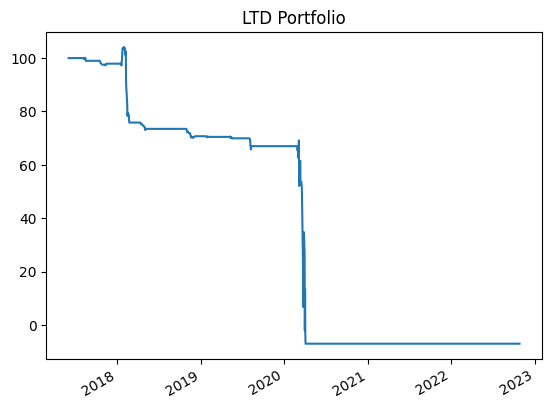

In [34]:
df_strategy_train['balance_sheet'].plot(title='LTD Portfolio');

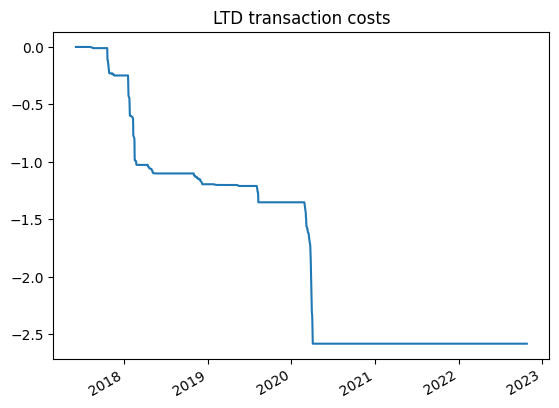

In [35]:
df_strategy_train['transaction_costs'].cumsum().plot(title='LTD transaction costs');

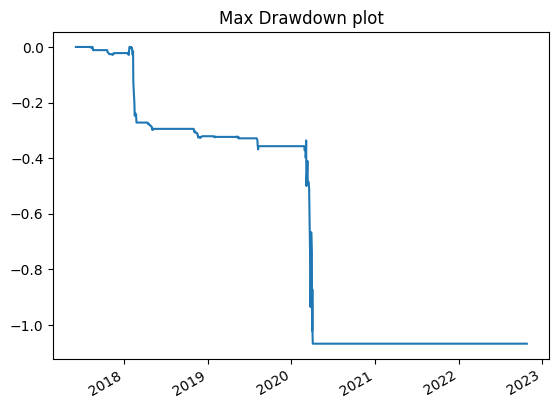

In [36]:
df_strategy_train['balance_sheet'].divide(df_strategy_train['balance_sheet'].expanding().max()).subtract(1.).plot(title='Max Drawdown plot');

In [37]:
def calculate_metrics_for_period(df, risk_free_rate=0.02):
    """
    Calculate metrics for a specific period of data.
    
    Parameters are same as calculate_trading_metrics
    """
    daily_returns = df['balance_sheet'].pct_change()
    annual_factor = 252

    start = df.index[0]
    end = df.index[-1]
    t = (end - start) / pd.Timedelta(days=365.25)
    
    def calculate_sharpe_ratio():
        excess_returns = daily_returns - risk_free_rate/annual_factor
        return np.sqrt(annual_factor) * (excess_returns.mean() / daily_returns.std())
    
    def calculate_sortino_ratio():
        excess_returns = daily_returns - risk_free_rate/annual_factor
        downside_returns = daily_returns[daily_returns < 0]
        downside_std = np.sqrt(np.mean(downside_returns**2))
        return np.sqrt(annual_factor) * (excess_returns.mean() / downside_std) if len(downside_returns) > 0 else np.nan
    
    def calculate_max_drawdown():
        cumulative = df['balance_sheet']
        rolling_max = cumulative.expanding().max()
        drawdowns = cumulative/rolling_max - 1
        return drawdowns.min()
    
    def calculate_calmar_ratio():
        total_days = (df.index[-1] - df.index[0]).days
        total_return = (df['balance_sheet'].iloc[-1] / df['balance_sheet'].iloc[0]) - 1
        annual_return = (1 + total_return) ** (365/total_days) - 1
        max_dd = abs(calculate_max_drawdown())
        return annual_return / max_dd if max_dd != 0 else np.nan

    total_return = (df['balance_sheet'].iloc[-1] / df['balance_sheet'].iloc[0]) - 1
    metrics = {
        'start_date': df.index[0].strftime('%Y-%m-%d'),
        'end_date': df.index[-1].strftime('%Y-%m-%d'),
        'trading_days': len(df),
        'initial_balance': df['balance_sheet'].iloc[0],
        'final_balance': df['balance_sheet'].iloc[-1],
        'total_return': total_return,
        'sharpe_ratio': calculate_sharpe_ratio(),
        'sortino_ratio': calculate_sortino_ratio(),
        'max_drawdown': calculate_max_drawdown(),
        'calmar_ratio': calculate_calmar_ratio(),
        'annualized_return': (1 + total_return) ** (1 / t) - 1,
        'annualized_volatility': daily_returns.std() * np.sqrt(annual_factor),
        'win_rate': len(daily_returns[daily_returns > 0]) / len(daily_returns[daily_returns != 0])
    }
    
    return metrics

def calculate_trading_metrics(df, risk_free_rate=0.02):
    """
    Calculate trading metrics for entire period and by year.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with datetime index and 'balance_sheet' column
    risk_free_rate (float): Annual risk-free rate, default 0.02 (2%)
    
    Returns:
    dict: Dictionary containing overall metrics and yearly breakdowns
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    # Calculate overall metrics
    overall_metrics = calculate_metrics_for_period(df, risk_free_rate)
    
    # Calculate yearly metrics
    yearly_metrics = {}
    for year in range(df.index[0].year, df.index[-1].year + 1):
        yearly_data = df[df.index.year == year]
        if not yearly_data.empty:
            yearly_metrics[year] = calculate_metrics_for_period(yearly_data, risk_free_rate)
    
    return {
        'overall': overall_metrics,
        'yearly': yearly_metrics
    }

In [38]:
summary = calculate_trading_metrics(df_strategy_train)
pd.concat((pd.Series(summary['overall'], name='Total'), pd.DataFrame(summary['yearly'])), axis=1).T.apply(pd.to_numeric, errors='ignore').round(4)

/tmp/ipykernel_1591/3849155824.py:33: RuntimeWarning: invalid value encountered in scalar power
  annual_return = (1 + total_return) ** (365/total_days) - 1
/tmp/ipykernel_1591/3849155824.py:49: RuntimeWarning: invalid value encountered in scalar power
  'annualized_return': (1 + total_return) ** (1 / t) - 1,
/tmp/ipykernel_1591/3849155824.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(annual_factor) * (excess_returns.mean() / daily_returns.std())
/tmp/ipykernel_1591/4179717567.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  pd.concat((pd.Series(summary['overall'], name='Total'), pd.DataFrame(summary['yearly'])), axis=1).T.apply(pd.to_numeric, errors='ignore').round(4)


,start_date,end_date,trading_days,initial_balance,final_balance,total_return,sharpe_ratio,sortino_ratio,max_drawdown,calmar_ratio,annualized_return,annualized_volatility,win_rate
Total,2017-06-02,2022-10-26,1150,100.0000,-7.0169,-1.0702,-0.4830,-0.1304,-1.0674,NaN,NaN,3.6686,0.3445
2017,2017-06-02,2017-12-29,64,100.0000,97.9154,-0.0208,-3.1322,-1.1156,-0.0285,-1.2620,-0.0360,0.0331,0.4286
2018,2018-01-03,2018-12-31,200,97.9154,70.7263,-0.2777,-2.3491,-1.1079,-0.3270,-0.8551,-0.2798,0.1768,0.3333
2019,2019-01-02,2019-12-31,224,70.7263,66.9962,-0.0527,-1.7643,-0.5508,-0.0698,-0.7598,-0.0531,0.0454,0.1818
2020,2020-01-02,2020-12-31,220,66.9962,-7.0169,-1.1047,-1.0435,-0.2548,-1.1014,NaN,NaN,8.4024,0.4348
2021,2021-01-04,2021-12-31,245,-7.0169,-7.0169,0.0000,-inf,NaN,0.0000,NaN,0.0000,0.0000,0.0000
2022,2022-01-03,2022-10-26,197,-7.0169,-7.0169,0.0000,-inf,NaN,0.0000,NaN,0.0000,0.0000,0.0000


In [39]:
BEST_PARAMS

{'latent_dim': 4,
 'out_channels': 0,
 'hidden_dim': 48,
 'learning_rate': 0.000562,
 'kl_loss_alpha': 1e-05,
 'correl_loss_alpha': 1e-05,
 'seed': 0,
 'num_epochs': 2000}

In [40]:
X.shape[0], train_idx.max(), test_idx[0]

(1643, 1149, 1150)

In [41]:
models = []
for idx in test_idx[::100]:
    print('\n', idx, valid_AsOfs[idx])
    best_loss, best_model, losses = run_for_param_set(**BEST_PARAMS, to_run_idx=np.arange(idx), test_count=50, )
    data = (idx, valid_AsOfs[idx], best_model)
    models.append(data)


 1150 2022-10-27 15:48:00-04:00
epoch=   0, epoch_loss=  6.2736 test_loss= 0.1243 np.log(test_loss)=-2.08
epoch= 100, epoch_loss=  0.0107 test_loss= 0.0004 np.log(test_loss)=-7.74
epoch= 200, epoch_loss=  0.0060 test_loss= 0.0004 np.log(test_loss)=-7.82
epoch= 300, epoch_loss=  0.0090 test_loss= 0.0003 np.log(test_loss)=-7.97
epoch= 400, epoch_loss=  0.0064 test_loss= 0.0003 np.log(test_loss)=-8.08
epoch= 500, epoch_loss=  0.0049 test_loss= 0.0003 np.log(test_loss)=-8.22
epoch= 600, epoch_loss=  0.0034 test_loss= 0.0002 np.log(test_loss)=-8.55
epoch= 700, epoch_loss=  0.0035 test_loss= 0.0002 np.log(test_loss)=-8.57
epoch= 800, epoch_loss=  0.0025 test_loss= 0.0001 np.log(test_loss)=-9.19
epoch= 900, epoch_loss=  0.0027 test_loss= 0.0001 np.log(test_loss)=-8.95
epoch=1000, epoch_loss=  0.0035 test_loss= 0.0001 np.log(test_loss)=-9.36
epoch=1100, epoch_loss=  0.0019 test_loss= 0.0001 np.log(test_loss)=-9.27
epoch=1200, epoch_loss=  0.0018 test_loss= 0.0001 np.log(test_loss)=-9.62
epoch

In [42]:
[(x[0], x[1]) for x in models]

[(1150, Timestamp('2022-10-27 15:48:00-0400', tz='US/Eastern')),
 (1250, Timestamp('2023-03-24 15:48:00-0400', tz='US/Eastern')),
 (1350, Timestamp('2023-08-23 15:48:00-0400', tz='US/Eastern')),
 (1450, Timestamp('2024-01-17 15:48:00-0500', tz='US/Eastern')),
 (1550, Timestamp('2024-06-12 15:48:00-0400', tz='US/Eastern'))]

In [43]:
previous = 0
recon_x, latent, logvar = [], [], []
for j in range(len(models)):
    if j==len(models)-1:
        train_idx = np.arange(previous, X.shape[0])
    else:
        train_idx = np.arange(previous, models[j+1][0])
    recon_x_, latent_, logvar_ = jax.vmap(lambda a, b: models[j][2](a, b, key=jax.random.PRNGKey(0)))(X[train_idx], y[train_idx])
    recon_x.append(recon_x_)
    latent.append(latent_)
    logvar.append(logvar_)
    previous = models[min(j+1, len(models)-1)][0]
recon_x = np.vstack(recon_x)
latent = np.vstack(latent)
logvar = np.vstack(logvar)

In [44]:
recon_x.shape, latent.shape, logvar.shape

((1643, 3, 11), (1643, 4), (1643, 4))

In [45]:
X_error = X - recon_x
X_error_z = expanding_z(X_error)

In [46]:
all_dates = pd.concat((pd.Series(valid_AsOfs[test_idx]), df_rolls['rolldatetime'])).sort_values().reset_index(drop=True)
all_dates = all_dates.loc[all_dates.le(valid_AsOfs[test_idx[-1]])]

CASH = 100.
DOWNSIDE_BREACH, DOWNSIDE_FLOOR = -3., -5
UPSIDE_BREACH, UPSIDE_CAP = 3., 5
EARLY_EXPIRE_DAYS = 3
HOLDING_PERIOD = half_lifes.mean() * 2.0
TRANSACTION_COSTS = 1e-4

In [47]:
b = run_trading_system(all_train_dates=all_dates, 
                       valid_AsOfs=valid_AsOfs, 
                       df_rolls=df_rolls, 
                       X_error_z=X_error_z, 
                       DOWNSIDE_BREACH=DOWNSIDE_BREACH,
                       DOWNSIDE_FLOOR=DOWNSIDE_FLOOR,
                       UPSIDE_BREACH=UPSIDE_BREACH,
                       UPSIDE_CAP=UPSIDE_CAP,
                       EARLY_EXPIRE_DAYS=EARLY_EXPIRE_DAYS,
                       TRANSACTION_COSTS=TRANSACTION_COSTS,
                       HOLDING_PERIOD=HOLDING_PERIOD,
                       days_to_run=None)

Output()

In [48]:
# b.snapshots

In [49]:
df_strategy = pd.DataFrame([x.model_dump() for x in b.snapshots], index=[x.when for x in b.snapshots])
df_strategy.head()

,when,cash,transaction_costs,assets_value,balance_sheet,n_trades,n_open_trades
2022-10-27 15:48:00-04:00,2022-10-27 15:48:00-04:00,100.0,0.0,0.0,100.0,0,0
2022-10-28 15:48:00-04:00,2022-10-28 15:48:00-04:00,100.0,0.0,0.0,100.0,0,0
2022-10-31 15:48:00-04:00,2022-10-31 15:48:00-04:00,100.0,0.0,0.0,100.0,0,0
2022-11-01 15:48:00-04:00,2022-11-01 15:48:00-04:00,100.0,0.0,0.0,100.0,0,0
2022-11-02 15:48:00-04:00,2022-11-02 15:48:00-04:00,100.0,0.0,0.0,100.0,0,0


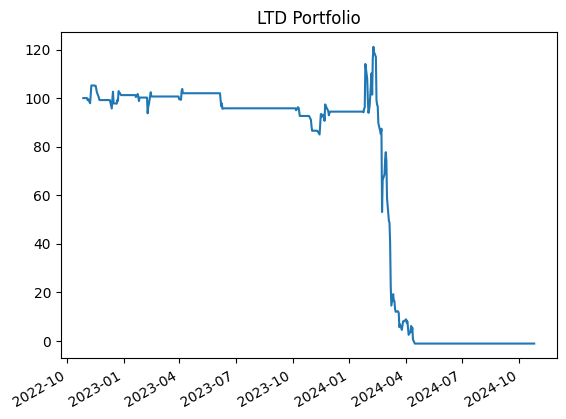

In [50]:
df_strategy['balance_sheet'].plot(title='LTD Portfolio');

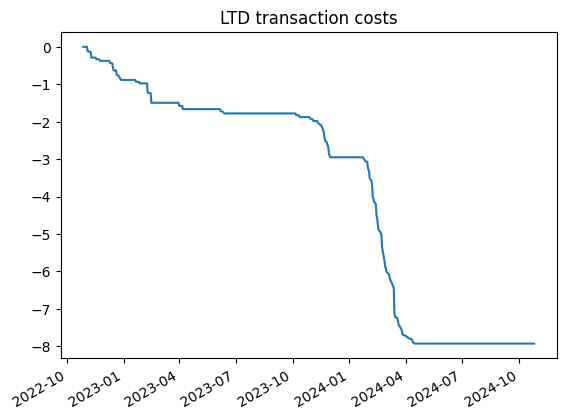

In [51]:
df_strategy['transaction_costs'].cumsum().plot(title='LTD transaction costs');

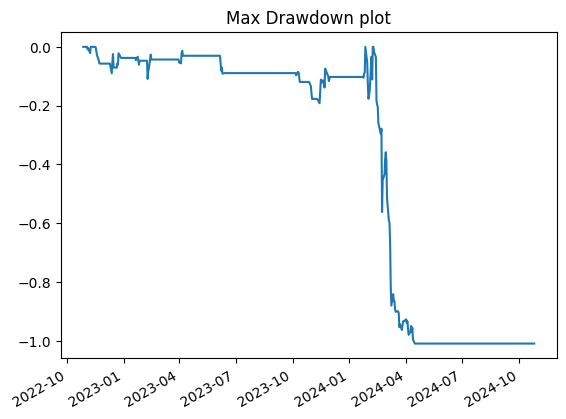

In [52]:
df_strategy['balance_sheet'].divide(df_strategy['balance_sheet'].expanding().max()).subtract(1.).plot(title='Max Drawdown plot');

In [53]:
summary = calculate_trading_metrics(df_strategy)
pd.concat((pd.Series(summary['overall'], name='Total'), pd.DataFrame(summary['yearly'])), axis=1).T.apply(pd.to_numeric, errors='ignore').round(3)

/tmp/ipykernel_1591/3849155824.py:33: RuntimeWarning: invalid value encountered in scalar power
  annual_return = (1 + total_return) ** (365/total_days) - 1
/tmp/ipykernel_1591/3849155824.py:49: RuntimeWarning: invalid value encountered in scalar power
  'annualized_return': (1 + total_return) ** (1 / t) - 1,
/tmp/ipykernel_1591/2269457054.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  pd.concat((pd.Series(summary['overall'], name='Total'), pd.DataFrame(summary['yearly'])), axis=1).T.apply(pd.to_numeric, errors='ignore').round(3)


,start_date,end_date,trading_days,initial_balance,final_balance,total_return,sharpe_ratio,sortino_ratio,max_drawdown,calmar_ratio,annualized_return,annualized_volatility,win_rate
Total,2022-10-27,2024-10-25,493,100.000,-1.182,-1.012,-0.958,-0.391,-1.010,NaN,NaN,2.843,0.390
2022,2022-10-27,2022-12-30,45,100.000,101.233,0.012,0.318,0.296,-0.090,0.803,0.072,0.267,0.304
2023,2023-01-03,2023-12-29,245,101.233,94.418,-0.067,-0.455,-0.224,-0.181,-0.377,-0.068,0.170,0.409
2024,2024-01-02,2024-10-25,203,94.418,-1.182,-1.013,-1.482,-0.638,-1.010,NaN,NaN,4.427,0.397
